In [1]:
""" IMPORTS """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import time
import re
import random
from PIL import Image
from tqdm.notebook import tqdm
from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.utils import shuffle
from SHG import SHG
from utils import *

In [2]:
""" PATHS """

TRAIN_IMGS_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/train/image/"
TRAIN_HEATMAPS_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/train/heatmaps/"
SAVED_MODEL_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/models/Mon_Apr_12_18-11-59_2021/epoch_46.pth"

In [3]:
""" DATASET AND DATALOADER """

average_rgb = np.loadtxt("./average_rgb.npy")

class dataset(Dataset):
    def __init__(self, X_path, y_path, average_rgb):
        self.X_path = X_path
        self.y_path = y_path
        self.X_data = os.listdir(self.X_path)
        self.average_rgb = average_rgb
        self.norm = transforms.Normalize(mean = self.average_rgb, std = [1, 1, 1])

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, i):
        ID = self.X_data[i]
        x = Image.open(self.X_path + ID)

        y = []

        for i in range(17):
            y.append(torch.from_numpy(np.load(self.y_path + ID[:-4] + "/" + str(i) + ".npy")))

        x = TF.to_tensor(x)

        if (x.shape[0] == 1): # If the image is gray-scale, cast it to rgb
            x = torch.stack((x[0],) * 3)

        x = self.norm(x) # Subtracts mean rgb

        y = torch.stack(y)
        return x, y, ID

train_data = dataset(TRAIN_IMGS_PATH, TRAIN_HEATMAPS_PATH, average_rgb)
train_dataloader = DataLoader(train_data)

In [4]:
""" MODELS """

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_skip = SHG(num_hourglasses=1).to(device)
model_skip.load_state_dict(torch.load(SAVED_MODEL_PATH))

model_no_skip = SHG(num_hourglasses=1, use_skip_connections = False).to(device)
model_no_skip.load_state_dict(torch.load(SAVED_MODEL_PATH))

<All keys matched successfully>

In [5]:
""" PREDICTIONS """

with torch.no_grad():
    model_skip.eval()
    model_no_skip.eval()

    IDs = []
    accs_skip = []
    accs_no_skip = []
    skips = 0

    for i, (x, y, z) in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        img = x.to(device, dtype = torch.float)
        gt_heatmaps = y.to(device, dtype = torch.float)
        ID = z

        pred_skip, _ = model_skip(img)
        pred_no_skip, _ = model_no_skip(img)

        if (torch.sum(gt_heatmaps.cpu()) != 0):
            pck = PCK(gt_heatmaps.cpu(), pred_skip.cpu())
            accs_skip.append(pck)
            pck = PCK(gt_heatmaps.cpu(), pred_no_skip.cpu())
            accs_no_skip.append(pck)
            IDs.append(ID)
        else:
            skips += 1
print("NUM SKIPS", skips)


NUM SKIPS 520


In [7]:
num_kps_dist = []

for _, y, _ in tqdm(train_dataloader, total = len(train_dataloader)):
    if (torch.sum(y) != 0):
        y = turn_featuremaps_to_keypoints(y)
        y = np.array(y).reshape((-1, 3))
        y = y[y[:, -1] != 0]
        num_kps_dist.append(y.shape[0])

KeyboardInterrupt: 

In [8]:
""" SAVES PREDICTION ACCURACIES """

IDs = np.array(IDs)
accs_no_skip = np.array(accs_no_skip)
accs_skip = np.array(accs_skip)
#num_kps_dist_perfect = np.array(num_kps_dist)
#num_kps_dist_perfect = num_kps_dist_perfect[accs_skip == 1]
#_, num_kps_dist_perfect_count = np.unique(num_kps_dist_perfect, return_counts = True)
np.save("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/accs_skip.npy", accs_skip)
np.save("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/accs_no_skip.npy", accs_no_skip)
np.save("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/IDs.npy", IDs)

In [6]:
""" LOADING PREDICTION ACCURACIES """

accs_skip = np.load("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/skin_cons/accs_skip.npy")
accs_no_skip = np.load("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/skin_cons/accs_no_skip.npy")
IDs = np.load("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/skin_cons/IDs.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/skin_cons/accs_skip.npy'

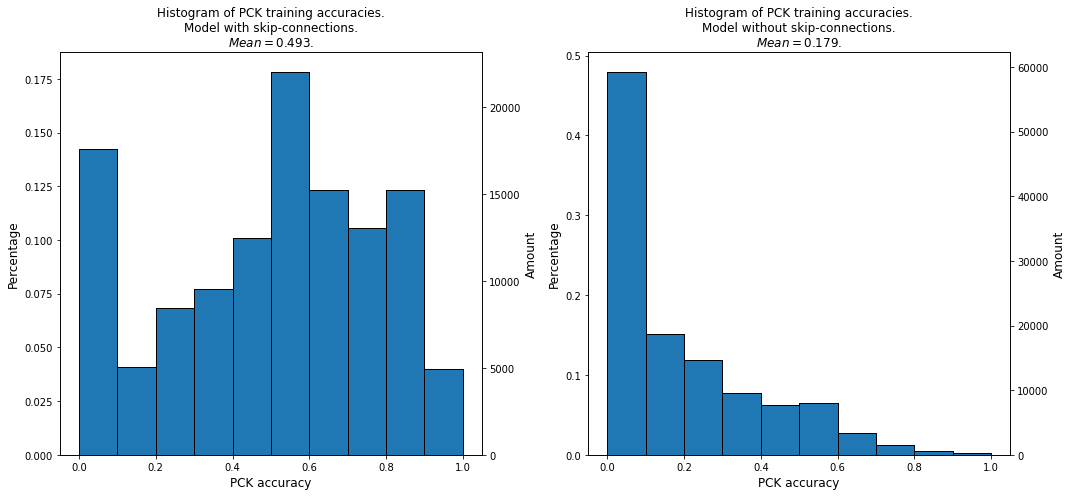

In [17]:
""" MAKING HISTOGRAMS OF ACCURACIES """

fig, axs = plt.subplots(1, 2, figsize = (15, 7))
weights = np.ones_like(accs_skip)/float(len(accs_skip))
NUM_BINS = 10
font_size = "large"

hist = axs[0].hist(accs_skip, bins = np.arange(0, 1.1, 0.1), edgecolor="black", weights = weights)
axs[0].set_title("Histogram of PCK training accuracies.\nModel with skip-connections.\n$Mean = {:.3f}$.".format(np.mean(accs_skip), np.median(accs_skip)), fontsize=font_size)
axs[0].set_ylabel("Percentage", fontsize=font_size)
axs[0].set_xlabel("PCK accuracy", fontsize=font_size)

axs2 = axs[0].twinx()
hist = axs2.hist(accs_skip, bins = np.arange(0, 1.1, 0.1), edgecolor="black")
axs2.set_ylabel("Amount", fontsize=font_size)

hist = axs[1].hist(accs_no_skip, bins = np.arange(0, 1.1, 0.1), edgecolor="black", weights = weights)
axs[1].set_title("Histogram of PCK training accuracies.\nModel without skip-connections.\n$Mean = {:.3f}$.".format(np.mean(accs_no_skip), np.median(accs_no_skip)), fontsize=font_size)
axs[1].set_ylabel("Percentage", fontsize=font_size)
axs[1].set_xlabel("PCK accuracy", fontsize=font_size)

axs2 = axs[1].twinx()
hist = axs2.hist(accs_no_skip, bins = np.arange(0, 1.1, 0.1), edgecolor="black")
axs2.set_ylabel("Amount", fontsize=font_size)

plt.tight_layout()
plt.savefig("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/PCK_accs_vs.png")

In [6]:
""" FINDING WHICH IDs RESULTED IN EACH MODELS PERFECT ACCURACIES """

perfect_skips = IDs[accs_skip == 1.0]
perfect_no_skips = IDs[accs_no_skip == 1.0]
perfect_both = IDs[np.logical_and(accs_no_skip == 1.0, accs_skip == 1.0)]
perfect_only_skip = IDs[np.logical_and(accs_no_skip != 1.0, accs_skip == 1.0)]

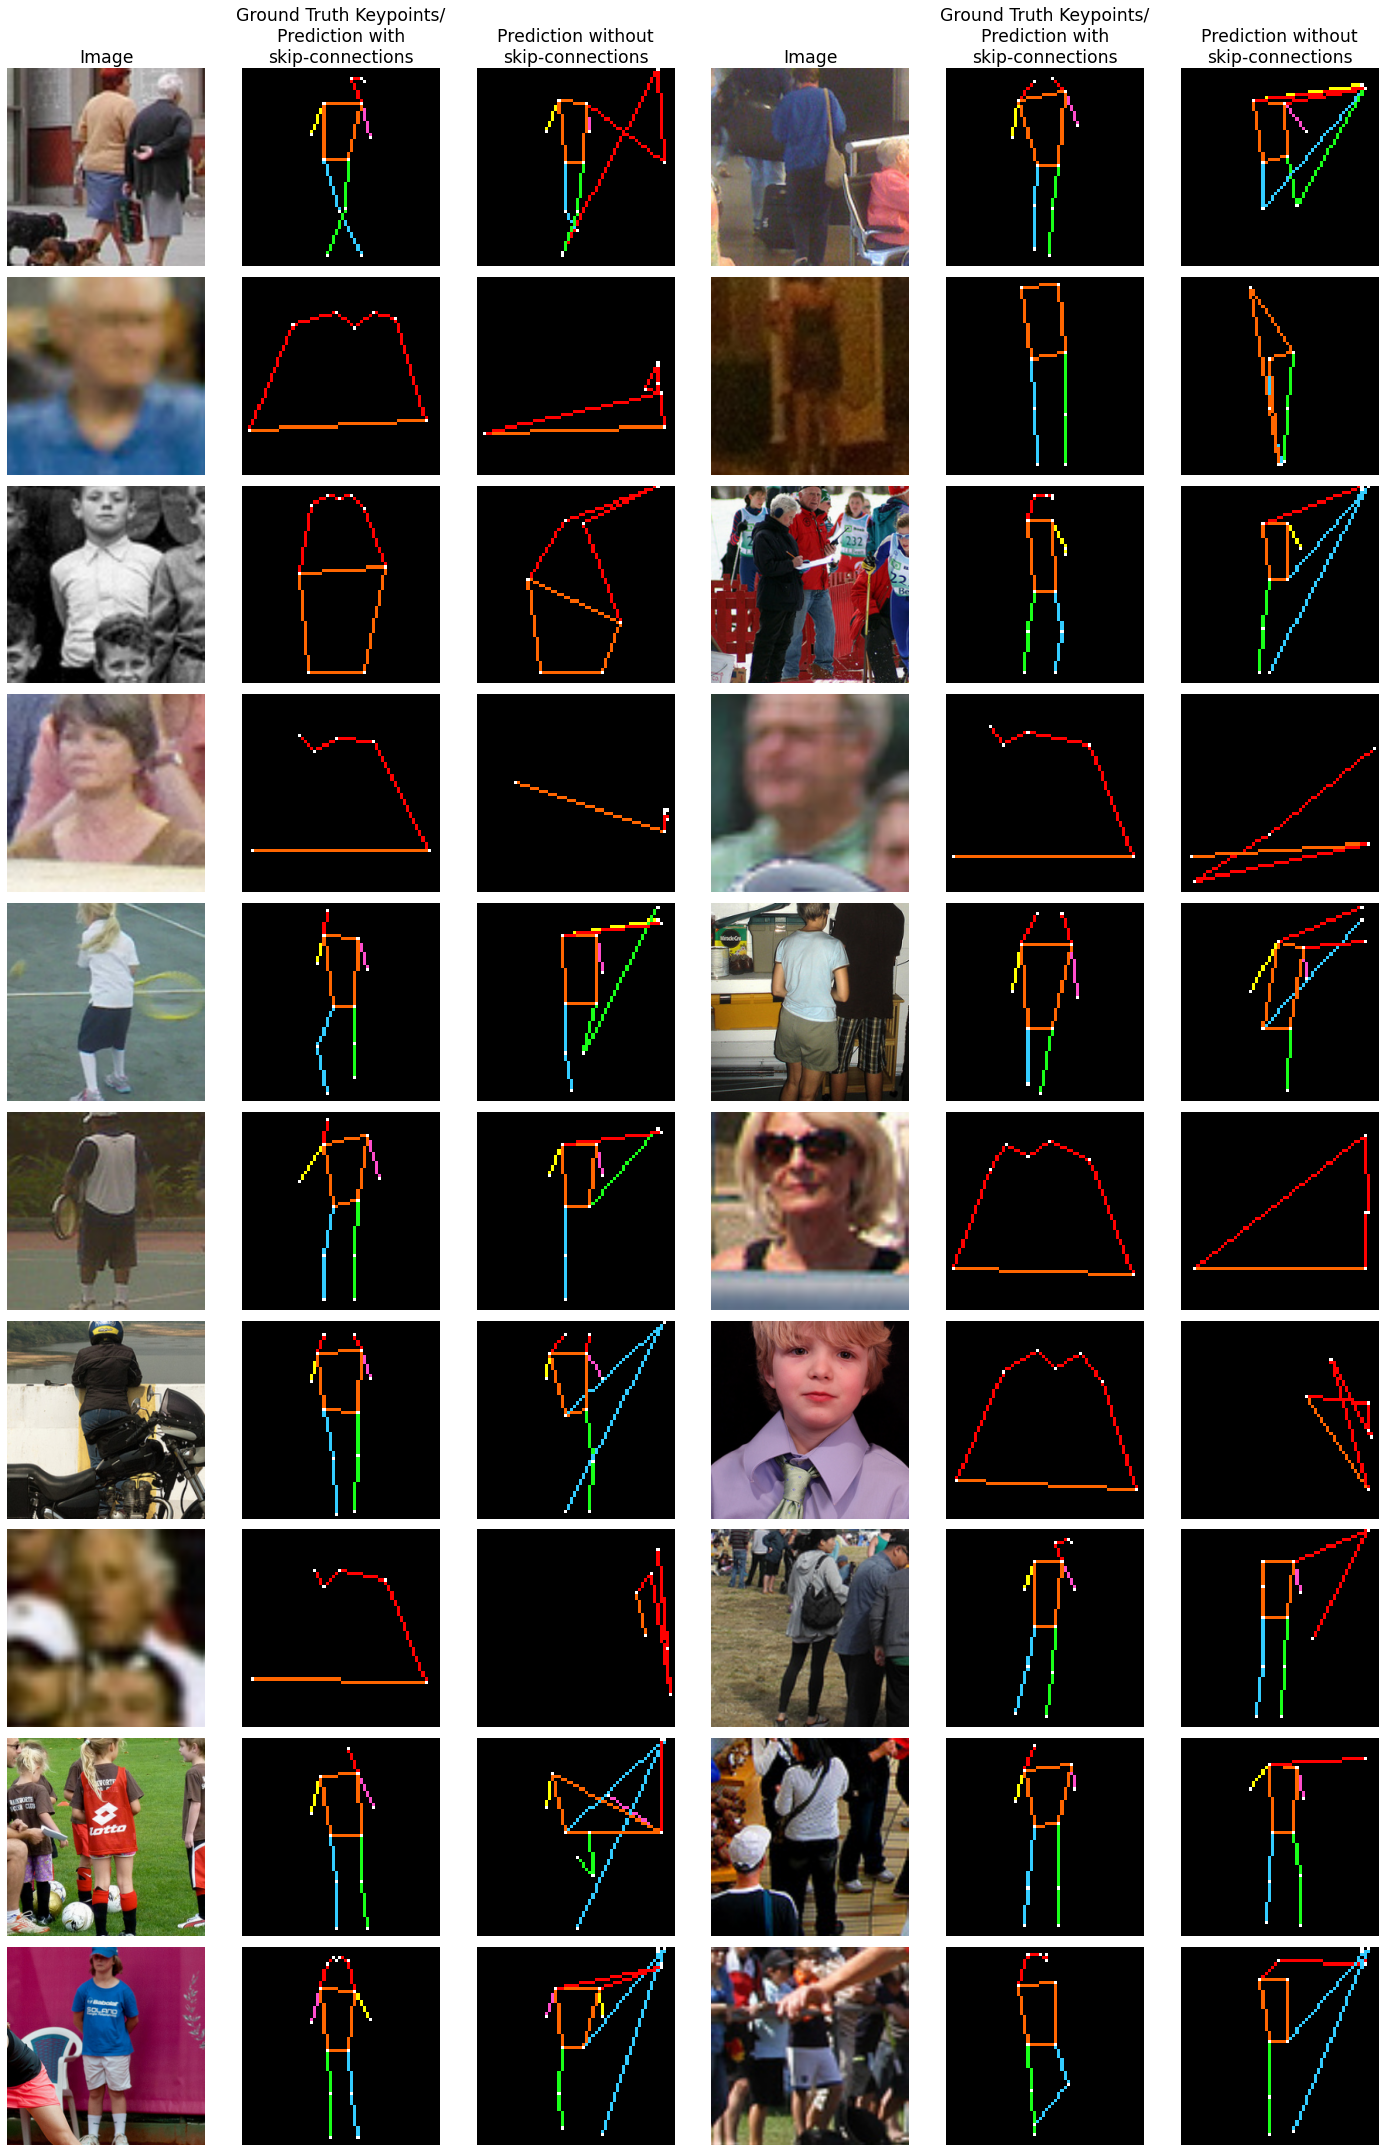

In [12]:
""" Samples of images where model with skip-cons got 100% accuracy """
NUM_POINTS = 20

imgs = []
gt_kps = []
model_with_skip_preds = []
model_without_skip_preds = []

choices = np.random.choice(perfect_skips.flatten(), replace = False, size = NUM_POINTS)

for choice in choices:
    # Loading input image
    img = Image.open(TRAIN_IMGS_PATH + choice)
    img = TF.to_tensor(img)

    if (img.shape[0] == 1): # If the image is gray-scale, cast it to rgb
        img = torch.stack((img[0],) * 3)

    imgs.append(torch.clone(img))
    TF.normalize(img, mean = average_rgb, std = [1, 1, 1], inplace = True)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

    # Loading gt heatmaps
    gt_kp = []
    for i in range(17):
        gt_kp.append(torch.from_numpy(np.load(TRAIN_HEATMAPS_PATH + choice[:-4] + "/" + str(i) + ".npy")))
    gt_kp = torch.stack(gt_kp)
    gt_kps.append(gt_kp)

    # Prediction with skip
    img = img.to(device, dtype = torch.float)
    pred, _ = model_skip(img)
    pred = draw_necessary_skeleton(turn_featuremaps_to_keypoints(pred.cpu()), turn_featuremaps_to_keypoints(gt_kp))
    model_with_skip_preds.append(pred)

    # Prediction without skip
    img = img.to(device, dtype = torch.float)
    pred, _ = model_no_skip(img)
    pred = draw_necessary_skeleton(turn_featuremaps_to_keypoints(pred.cpu()), turn_featuremaps_to_keypoints(gt_kp))
    model_without_skip_preds.append(pred)

fig, axs = plt.subplots(NUM_POINTS//2, 6, figsize = (20, 30))

for i in range(NUM_POINTS//2):
    axs[i, 0].imshow(imgs[i].permute(1, 2, 0).data.numpy())
    axs[i, 0].axis("off")

    if (i == 0):
        axs[i, 0].set_title("Image", size = "xx-large")

    axs[i, 1].imshow(draw_skeleton(turn_featuremaps_to_keypoints(gt_kps[i])))
    axs[i, 1].axis("off")

    if (i == 0):
        axs[i, 1].set_title("Ground Truth Keypoints/\nPrediction with\nskip-connections", size = "xx-large")

    axs[i, 2].imshow(model_without_skip_preds[i])
    axs[i, 2].axis("off")

    if (i == 0):
        axs[i, 2].set_title("Prediction without\nskip-connections", size = "xx-large")


    axs[i, 3].imshow(imgs[NUM_POINTS//2 + i].permute(1, 2, 0).data.numpy())
    axs[i, 3].axis("off")

    if (i == 0):
        axs[i, 3].set_title("Image", size = "xx-large")

    axs[i, 4].imshow(draw_skeleton(turn_featuremaps_to_keypoints(gt_kps[NUM_POINTS//2 + i])))
    axs[i, 4].axis("off")

    if (i == 0):
        axs[i, 4].set_title("Ground Truth Keypoints/\nPrediction with\nskip-connections", size = "xx-large")

    axs[i, 5].imshow(model_without_skip_preds[NUM_POINTS//2 + i])
    axs[i, 5].axis("off")

    if (i == 0):
        axs[i, 5].set_title("Prediction without\nskip-connections", size = "xx-large")

plt.tight_layout()
plt.savefig("C:/Users/André/OneDrive 2/OneDrive/Skrivebord/pred_comparisons.png")
plt.show()